In [ ]:
# Ejecución en simulador AER, fecha: 08/05/2025

In [5]:
import qiskit
import qiskit_aer
print("Qiskit version:", qiskit.__version__)
print("Qiskit Aer version:", qiskit_aer.__version__)


Qiskit version: 1.4.2
Qiskit Aer version: 0.17.0


In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import time
import numpy as np
import pandas as pd

# Definir el número de shots
num_shots = 1024  

# Definir el grafo del problema Max-Cut
edges = {(0, 1): 1, (1, 2): 1, (2, 3): 1, (0, 3): 1}
num_nodes = 4

# Valor de corte óptimo, en este caso no se usa al conocer las configuraciones óptimas
opt_value = 4 

# Estados óptimos para este grafo
opt_states = ['0101', '1010']

# Algoritmo QAOA
def generate_QAOA(edges, beta, gamma):
    assert len(beta) == len(gamma), "Gamma y Beta no tienen la misma longitud"

    num_levels = len(beta)
    qreg = QuantumRegister(num_nodes, "q")
    creg = ClassicalRegister(num_nodes, "c")
    circ = QuantumCircuit(qreg, creg)

    # Inicio superposición
    circ.h(qreg) 

    for level in range(num_levels):
        # Phase Separator
        for (i, j), weight in edges.items():
            circ.cx(qreg[i], qreg[j])
            circ.rz(2 * gamma[level] * weight, qreg[j])
            circ.cx(qreg[i], qreg[j])

        # Mixer
        for i in range(num_nodes):
            circ.rx(2 * beta[level], qreg[i])

    # Medida
    circ.measure(qreg, creg)
    return circ

# Parámetros de QAOA
beta = [0.5, 0.5]
gamma = [1.0, 1.0]
circuit = generate_QAOA(edges, beta, gamma)

# Usar el simulador AER
simulator = AerSimulator()
transpiled_circuit = transpile(circuit, simulator)

# Ejecutar QAOA y medir el tiempo
start_time = time.time()
job = simulator.run(transpiled_circuit, shots=num_shots)  
result = job.result()
end_time = time.time()

counts = result.get_counts()
t_sample = (end_time - start_time) * 1000  

# Calcular el tiempo por muestra
t_sample_per_sample = t_sample / num_shots 

print("Resultados de la simulación:", counts)
print("Tiempo total (t_sample):", t_sample, "ms")
print("Tiempo por muestra (t_sample_per_sample):", t_sample_per_sample, "ms")


print("Valor óptimo (Opt):", opt_value)

#  Calcular P_GS y TTS 
def calculate_P_GS_and_TTS(counts, opt_states, t_sample):
    # Sumar las frecuencias de todos los estados óptimos entre shots totales
    p_gs = sum(counts.get(state, 0) for state in opt_states) / sum(counts.values())

    # Calcular TTS
    if p_gs == 0:
        tts = float('inf') 
    elif p_gs == 1:
        tts = t_sample 
    else:
        tts = t_sample * np.max([np.ones_like(p_gs), np.abs(np.log(0.01) / np.log(1 - p_gs))], axis=0)

    return p_gs, tts



# Calcular métricas
p_gs, tts = calculate_P_GS_and_TTS(counts, opt_states, t_sample_per_sample)
print("P_GS (corregido):", p_gs)
print("TTS (corregido):", tts, "ms")

# Crear tabla en Jupyter
data = {
    "Instance": ["(4, 4, 0)"],  # Identificador del grafo
    "Opt": [opt_value],         # Valor óptimo
    "P_GS": [p_gs],             # Probabilidad de éxito
    "t_sample (ms)": [t_sample], # Tiempo total por muestra
    "TTS (ms)": [tts]           # Tiempo total (TTS)
}

# Crear el DataFrame
df = pd.DataFrame(data)

# Mostrar la tabla
display(df)


Resultados de la simulación: {'1011': 5, '1110': 5, '1010': 470, '0011': 8, '0111': 9, '1100': 2, '0101': 485, '1001': 6, '0010': 5, '0001': 7, '1000': 7, '0110': 7, '1101': 4, '0100': 4}
Tiempo total (t_sample): 2.993345260620117 ms
Tiempo por muestra (t_sample_per_sample): 0.002923188731074333 ms
Valor óptimo (Opt): 4
P_GS (corregido): 0.9326171875
TTS (corregido): 0.004990715046033333 ms


,Instance,Opt,P_GS,t_sample (ms),TTS (ms)
0,"(4, 4, 0)",4,0.932617,2.993345,0.004991


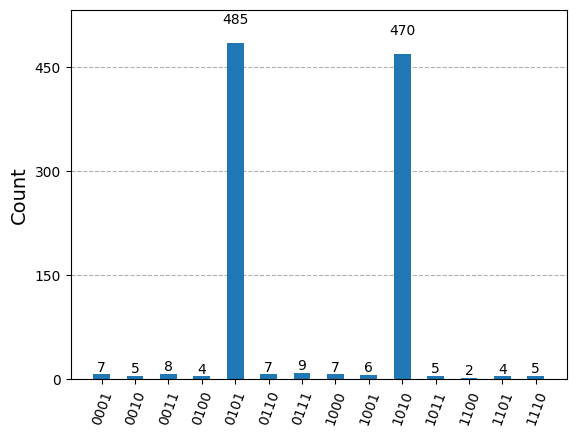

In [6]:
from qiskit.visualization import plot_histogram
plot_histogram(counts) 

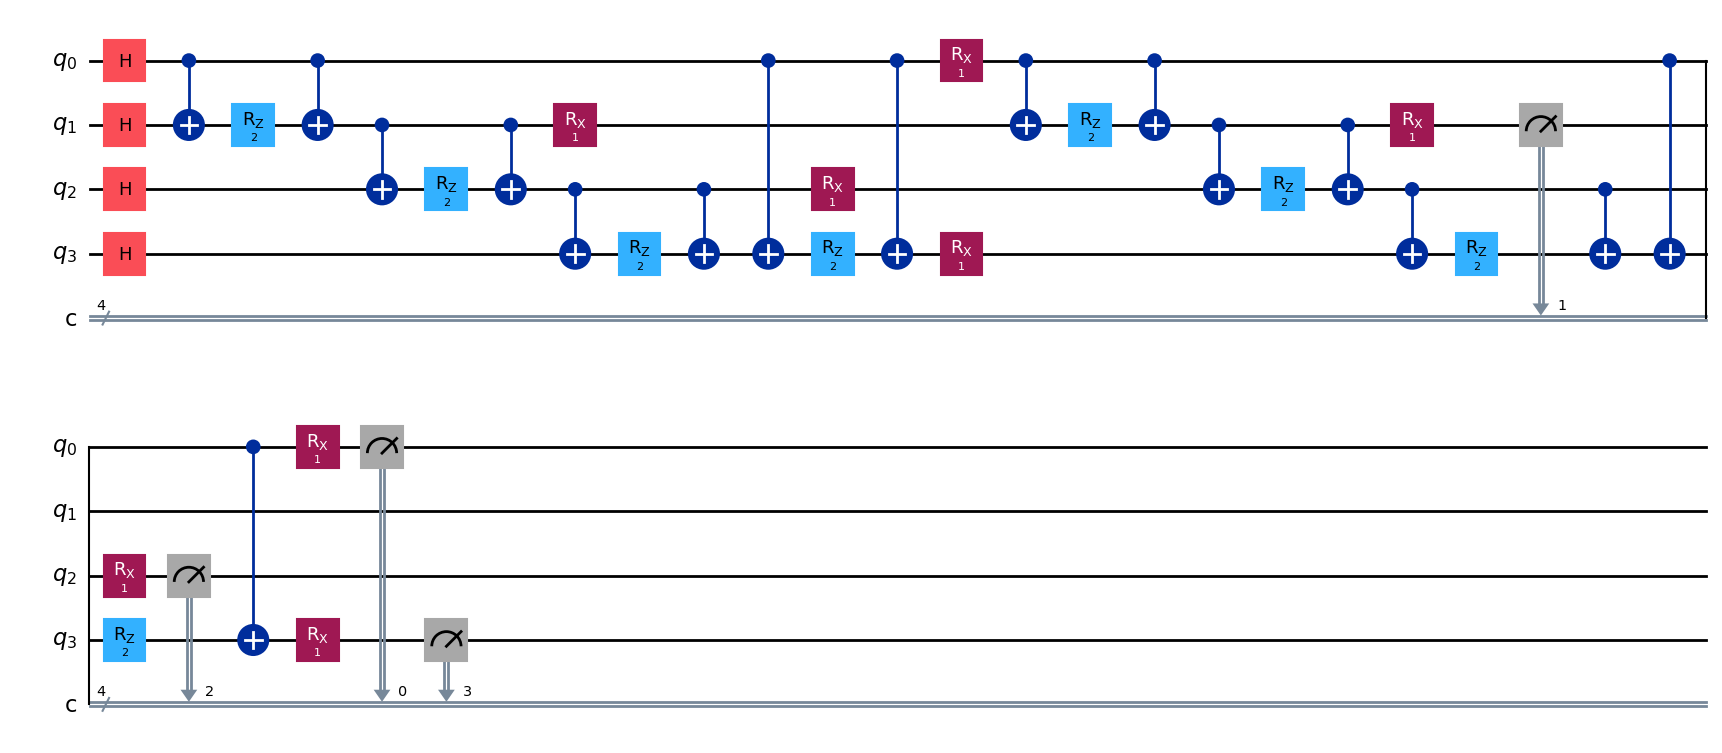

In [6]:
circuit.draw("mpl")